Look at this issue:

https://www.kaggle.com/datasets/utkarshx27/american-companies-bankruptcy-prediction-dataset/discussion/434421



Looking at the data, I noticed that among all the companies, there is never a case where the status changes from 'alive' to 'failed' when the year changes. In addition, companies, that started as 'failed', maintain this status until they are removed from the dataset. This implies that if we simply predict the value based on the previous year's status, the accuracy becomes 100% without using other features. What is the reason for this problem? Is this dataset representing real-world data?

Please sign in to reply to this topic.


2 Comments
Hotness
PramodGupta
Posted a year ago

This post earned a bronze medal
I think for a failed company, last FY is the bankruptcy date and they have marked all FY previous to that as failed as well. For eg. C_186 has data starting from 1999 and till 2012. Company went bankrupt in 2012/2013.

Alfredo Sepúlveda-Jiménez
Posted 3 months ago


So, in data preprocessing one would have to change a company's bankruptcy status (status) to "alive" for all years before its last FY listed. Regardless of this, this dataset, as with most bankruptcy datasets, is imbalanced (many more solvent company years than bankrupt ones) and will cause bias leakage in any classical regression or ML algorithm. One should equally consider, for each company listed, distressed KPI or ratio trends during those listed years to predict subsequent bankruptcies. These are therefore short-term time-series aggregates.

In [78]:
import pandas as pd
import numpy as np
import os
import sys

df = pd.read_csv('american_bankruptcy.csv')
df.head()


,company_name,status_label,year,X1,X2,X3,X4,X5,X6,X7,...,X9,X10,X11,X12,X13,X14,X15,X16,X17,X18
0,C_1,alive,1999,511.267,833.107,18.373,89.031,336.018,35.163,128.348,...,1024.333,740.998,180.447,70.658,191.226,163.816,201.026,1024.333,401.483,935.302
1,C_1,alive,2000,485.856,713.811,18.577,64.367,320.590,18.531,115.187,...,874.255,701.854,179.987,45.790,160.444,125.392,204.065,874.255,361.642,809.888
2,C_1,alive,2001,436.656,526.477,22.496,27.207,286.588,-58.939,77.528,...,638.721,710.199,217.699,4.711,112.244,150.464,139.603,638.721,399.964,611.514
3,C_1,alive,2002,396.412,496.747,27.172,30.745,259.954,-12.410,66.322,...,606.337,686.621,164.658,3.573,109.590,203.575,124.106,606.337,391.633,575.592
4,C_1,alive,2003,432.204,523.302,26.680,47.491,247.245,3.504,104.661,...,651.958,709.292,248.666,20.811,128.656,131.261,131.884,651.958,407.608,604.467


In [79]:
unique_companies = df['company_name'].unique()
len(unique_companies)

8971

In [80]:
df.sort_values(['company_name','year'], inplace=True)
# df.sort_values('year', inplace=True)



In [81]:
# all_survival_info[all_survival_info['delta'] == 1]

Modeling survival of company post 1999 should use covars in 1999 only:
How many years would a company survive (given that this company is within the data for 1999?)

In [82]:
covars_start = df[df['year'] == 1999]
len(covars_start), covars_start.head()

(5308,
       company_name status_label  year        X1         X2       X3       X4  \
 0              C_1        alive  1999   511.267    833.107   18.373   89.031   
 110           C_10        alive  1999   498.794   1459.008  385.568  964.345   
 1198         C_100        alive  1999    23.527     17.916    5.252   19.892   
 11926       C_1000        alive  1999  1553.725   1908.784  137.696  813.734   
 11946       C_1001        alive  1999  7965.500  34240.100  171.700  308.200   
 
              X5       X6        X7  ...         X9        X10       X11  \
 0       336.018   35.163   128.348  ...   1024.333    740.998   180.447   
 110      91.846  168.903   317.518  ...   2423.353   6608.506  2206.052   
 1198      0.892    9.488     7.967  ...     40.252     71.001     0.000   
 11926   295.255  425.764  1052.606  ...   3991.997   4088.797   354.775   
 11946  4149.300  723.700  3034.500  ...  36712.500  10372.900  1439.600   
 
            X12       X13       X14       X15  

In [83]:
company_started_in_1999 = covars_start['company_name'].unique()

Covariates Xs and survival for next year, clearly, one company can only fail for 1 time, so this gives an overfit

In [84]:
def gather_lag_data(df, company_name):
    cases = df[df['company_name'] == company_name]
    cases_labels = cases['status_label'].values
    assert len(np.unique(cases_labels)) == 1, f'There should be only 1 case for {company_name}'
    if any(cases_labels == 'failed'):
        delta = 1
    else:
        delta = 0
    t_tilde = len(cases_labels)

        
    if delta ==1:
        X = cases.drop(columns=['company_name', 'year', 'status_label']).values
        y = np.array([0 for i in range(len(X)-1)] + [1])


    else:
        X = cases.drop(columns=['company_name', 'year', 'status_label']).iloc[:-1,:].values
        y = np.array([0 for i in range(len(X))]) # we don't know if it survived the next year

    return X, y


In [85]:


all_lag_covariates = []
deaths_at_j = []

for company_name in unique_companies:
    X, y = gather_lag_data(df, company_name)
    all_lag_covariates.append(X)
    deaths_at_j.append(y)

Xs = np.vstack(all_lag_covariates)
ys = np.hstack(deaths_at_j)




In [86]:
Xs.shape, ys.shape

((70320, 18), (70320,))

note that logistic solver is iterative. this dataset is very large and you need to set max iter high

Confusion Matrix:
[[69701    10]
 [  598    11]]
ROC-AUC: 0.858897438613498


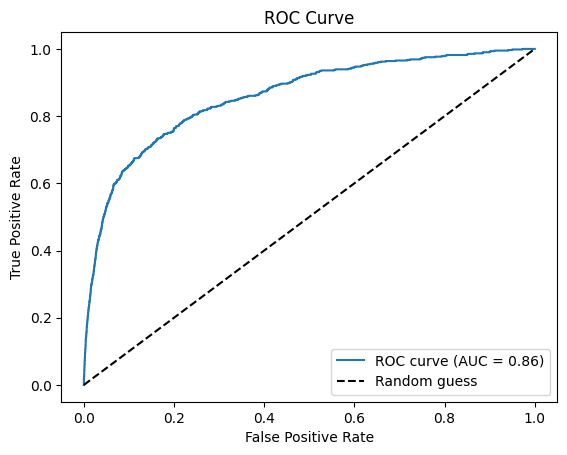

In [87]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Initialize the logistic regression model
logistic_model = LogisticRegression(max_iter=100000)

# Fit the model with X and y
logistic_model.fit(Xs, ys)

# Predict probabilities and classes
y_pred = logistic_model.predict(Xs)
y_prob = logistic_model.predict_proba(Xs)[:, 1]

# Compute confusion matrix
conf_matrix = confusion_matrix(ys, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Compute ROC-AUC
roc_auc = roc_auc_score(ys, y_prob)
print("ROC-AUC:", roc_auc)

# Plot ROC curve
fpr, tpr, _ = roc_curve(ys, y_prob)
plt.figure()
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], 'k--', label="Random guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()

In [88]:
# Compute confusion matrix
conf_matrix = confusion_matrix(ys, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Extract values from the confusion matrix
true_negatives, false_positives = conf_matrix[0]
false_negatives, true_positives = conf_matrix[1]

# Compute recall and precision
recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0

# Compute F1 score
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

print(f"Recall: {recall:.2f}")
print(f"Precision: {precision:.2f}")
print(f"F1 Score: {f1_score:.2f}")

# Compute ROC-AUC
roc_auc = roc_auc_score(ys, y_prob)
print("ROC-AUC:", roc_auc)

Confusion Matrix:
[[69701    10]
 [  598    11]]
Recall: 0.02
Precision: 0.52
F1 Score: 0.03
ROC-AUC: 0.858897438613498




Above shows if we model 
$$\mathbb{P}(death[j]|death[j-1]^c, X_d[*j-1])$$

 for 1 term only, we can get good ROC-AUC, but not good confusion matrix.

But as Filtration $\mathcal{F}$ goes with t, once we know the company survived at $t=j$ we actually have all the historical data up till j, we can use all information up to $j-1$ to model if it fails at $j$

We instead model

$$ \mathbb{P}(death[j]|death[j-1]^c, X_d[0:j-1]) $$



several problems : 

 - the dataset is very imbalanced (death is rare), and for one list of pairs of $[(death_j; history_<j)]_i$ this will be even more imbalanced. But we actually care more on the death cases and we care about the F-1 and recall score. 

 - histories are in different lengths, we need to use a model that supports input of a historical sequence of vars of different lengths. but we cannot throw a very over-parameterized model for both difficulty of identification and numerical issues

 - we need to use the time series split. results uses failure data upto some points to train it, and use data label for afterward for a test.

**if you train a model without upweighting death, the score will look very good--but that is not useful because a very good score can also be achieved through guessing that no deaths happens at all**

then we compute the $P, R, F1$ of this test set



**we also need to make sure missingness of data after the cut year, given that the company survived at the cut year or later, is not dependent to survival time for selection**


In [89]:
unique_companies

array(['C_1', 'C_2', 'C_3', ..., 'C_8969', 'C_8970', 'C_8971'],
      shape=(8971,), dtype=object)

In [90]:
train_rebalanced_model = True

Using device: cuda
Epoch 1/500 - Train Loss: 0.653527 - AUC: 0.8475 P: 0.7332 R: 0.8671 F1: 0.7946
Epoch 2/500 - Train Loss: 0.623482 - AUC: 0.8347 P: 0.7409 R: 0.7919 F1: 0.7656
Epoch 3/500 - Train Loss: 0.616809 - AUC: 0.8427 P: 0.7665 R: 0.8035 F1: 0.7846
Epoch 4/500 - Train Loss: 0.612889 - AUC: 0.8533 P: 0.7728 R: 0.8092 F1: 0.7906
Epoch 5/500 - Train Loss: 0.610296 - AUC: 0.8616 P: 0.7831 R: 0.8150 F1: 0.7987
Epoch 6/500 - Train Loss: 0.607444 - AUC: 0.8600 P: 0.7830 R: 0.8208 F1: 0.8015
Epoch 7/500 - Train Loss: 0.605052 - AUC: 0.8578 P: 0.7922 R: 0.8092 F1: 0.8006
Epoch 8/500 - Train Loss: 0.603132 - AUC: 0.8616 P: 0.7924 R: 0.8150 F1: 0.8036
Epoch 9/500 - Train Loss: 0.600536 - AUC: 0.8616 P: 0.7970 R: 0.8382 F1: 0.8171
Epoch 10/500 - Train Loss: 0.598460 - AUC: 0.8631 P: 0.8077 R: 0.8150 F1: 0.8113
Epoch 11/500 - Train Loss: 0.596067 - AUC: 0.8599 P: 0.8067 R: 0.8150 F1: 0.8108
Epoch 12/500 - Train Loss: 0.595046 - AUC: 0.8627 P: 0.8055 R: 0.8382 F1: 0.8215
Epoch 13/500 - Tra

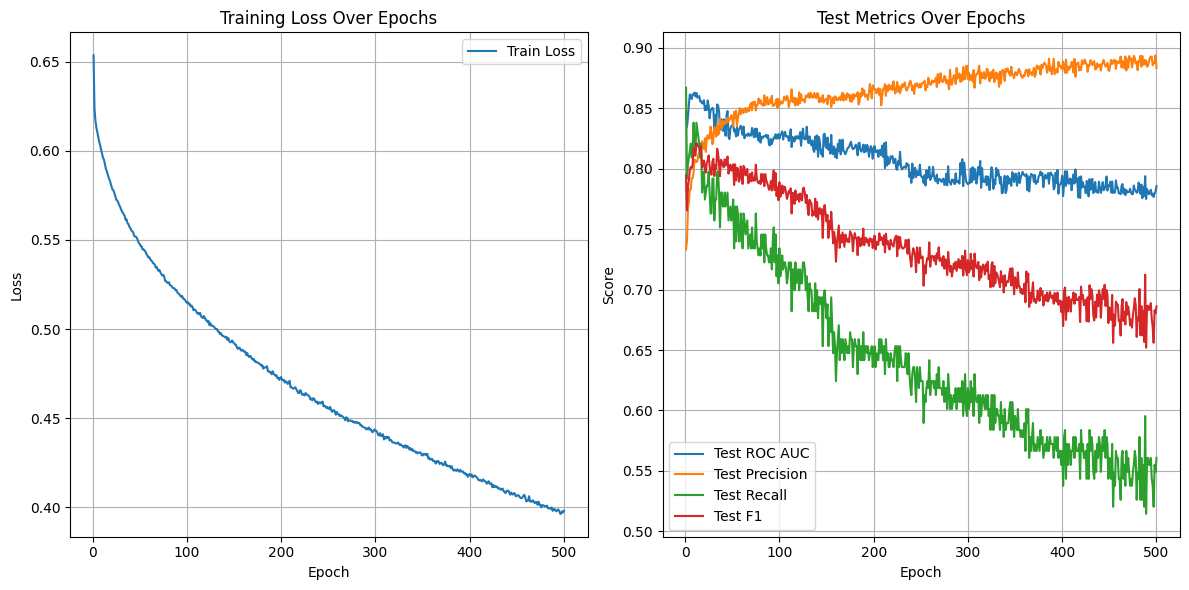

In [91]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

# =============================
# Sequence Creation
# =============================
def create_sequences(data, n_history):
    return np.array([data[i:i + n_history] for i in range(len(data) - n_history + 1)])

# =============================
# Dataset Preparation by Year
# =============================
def prepare_dataset_by_year(df, n_history=3, n_increment=2, max_samples=10000, cutoff_year=2013,
                            upweight_failed=100):
    train_X, train_y, test_X, test_y = [], [], [], []
    unique_companies = df['company_name'].unique()

    for company in unique_companies:
        company_data = df[df['company_name'] == company].sort_values('year').reset_index(drop=True)
        years = company_data['year'].values
        labels = company_data['status_label'].values
        features = company_data.drop(columns=['company_name', 'year', 'status_label']).values

        if len(features) < n_history:
            continue

        has_failed = any(labels == 'failed')
        X_seq = create_sequences(features, n_history)
        y_seq = [1 if has_failed and i == len(X_seq) - 1 else 0 for i in range(len(X_seq))]
        seq_years = years[n_history - 1:]

        for x, y_label, year in zip(X_seq, y_seq, seq_years):
            if year < cutoff_year:
                train_X.append(x)
                train_y.append(y_label)
                if upweight_failed and y_label == 1:
                    for k in range(upweight_failed - 1):
                        train_X.append(x)
                        train_y.append(y_label)

            else:
                test_X.append(x)
                test_y.append(y_label)

                if upweight_failed and y_label == 1:
                    for k in range(upweight_failed - 1):
                        test_X.append(x)
                        test_y.append(y_label)
                        

    return (np.array(train_X), np.array(train_y),
            np.array(test_X), np.array(test_y))

# =============================
# Dataset Class
# =============================
class CompanyFailureDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# =============================
# Transformer Model
# =============================
class TransformerFailurePredictor(nn.Module):
    def __init__(self, input_dim, d_model=64, nhead=4, num_layers=2):
        super().__init__()
        self.embedding = nn.Linear(input_dim, d_model)
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.norm = nn.LayerNorm(d_model)
        self.classifier = nn.Sequential(
            nn.Linear(d_model,4),
            nn.ReLU(),
            nn.Linear(4, 1)
        )

    def forward(self, x):
        x = self.embedding(x)
        x = self.transformer(x)
        x = self.norm(x.mean(dim=1))
        return self.classifier(x).squeeze(-1)

# =============================
# Training Loop with Evaluation
# =============================


from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score

def train_model(model, train_loader, test_loader, device, num_epochs=10, lr=1e-4):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.BCEWithLogitsLoss()

    train_losses = []
    test_metrics = []  # stores (auc, precision, recall, f1)

    for epoch in range(num_epochs):
        model.train()
        total_train_loss = 0.0

        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            total_train_loss += loss.item() * X_batch.size(0)

        avg_train_loss = total_train_loss / len(train_loader.dataset)
        train_losses.append(avg_train_loss)

        # Evaluation
        model.eval()
        all_outputs = []
        all_labels = []
        with torch.no_grad():
            for X_batch, y_batch in test_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                outputs = model(X_batch)
                all_outputs.append(outputs.cpu())
                all_labels.append(y_batch.cpu())

        all_outputs = torch.cat(all_outputs)
        all_labels = torch.cat(all_labels)

        probs = torch.sigmoid(all_outputs).numpy()
        preds = (probs > 0.5).astype(int)
        true_labels = all_labels.numpy()

        # Compute metrics
        try:
            auc = roc_auc_score(true_labels, probs)
        except ValueError:
            auc = float('nan')  # handle case with only one class in y_true

        precision = precision_score(true_labels, preds, zero_division=0)
        recall = recall_score(true_labels, preds, zero_division=0)
        f1 = f1_score(true_labels, preds, zero_division=0)

        test_metrics.append((auc, precision, recall, f1))

        print(f"Epoch {epoch + 1}/{num_epochs} - Train Loss: {avg_train_loss:.6f} "
              f"- AUC: {auc:.4f} P: {precision:.4f} R: {recall:.4f} F1: {f1:.4f}")

    return train_losses, test_metrics

# =============================
# Run Pipeline (Main Script)
# =============================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# EXAMPLE: you must load your dataframe `df` beforehand with proper columns
# Example: df = pd.read_csv("your_data.csv")

X_train, y_train, X_test, y_test = prepare_dataset_by_year(df, n_history=3, n_increment=2, max_samples=100000, cutoff_year=2013)

train_dataset = CompanyFailureDataset(X_train, y_train)
test_dataset = CompanyFailureDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=8192, shuffle=True, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=8192, shuffle=False, pin_memory=True)

input_dim = X_train.shape[2]
if train_rebalanced_model:
    model = TransformerFailurePredictor(input_dim, d_model=8).to(device)

    NUM_EPOCHS = 500


    # Run training
    train_losses, test_metrics = train_model(model, train_loader, test_loader, device, num_epochs=NUM_EPOCHS, lr=1e-4)

    # Unpack test metrics
    test_auc = [m[0] for m in test_metrics]
    test_precision = [m[1] for m in test_metrics]
    test_recall = [m[2] for m in test_metrics]
    test_f1 = [m[3] for m in test_metrics]

    # Plot train loss + test AUC

    # Plot train loss + test AUC
    epochs = range(1, NUM_EPOCHS + 1)
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Train Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss Over Epochs')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(epochs, test_auc, label='Test ROC AUC')
    plt.plot(epochs, test_precision, label='Test Precision')
    plt.plot(epochs, test_recall, label='Test Recall')
    plt.plot(epochs, test_f1, label='Test F1')
    plt.xlabel('Epoch')
    plt.ylabel('Score')
    plt.title('Test Metrics Over Epochs')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.savefig('train_test_metrics.pdf')


Suggesting if you re-sample the $(history \rightarrow survival at time j)$ pair with a 1:1 ratio, the model does make a generalizable prediction much better than guessing, albeit it does not mean it generates good prediction for the tail for 2 reasons: the real death to live ratio at jth year is always imbalanced, and iteratively predicting the tail leads to error accumulation

(Some irrelevant machine learning observations)It results from the abrupt jump in metrics, such as precision and recall, at the very start of training—likely due to initial model predictions heavily favoring a single class. After a few epochs, predictions become balanced, and these metrics stabilize, producing smoother curves.

In [92]:
torch.cuda.is_available()

True

In [93]:
# Summarize the values of y_train
unique_y, counts_y = np.unique(y_train, return_counts=True)
print("Summary of y_train:")
for value, count in zip(unique_y, counts_y):
    print(f"Value: {value}, Count: {count}")

# Summarize the values of y_test
unique_y_test, counts_y_test = np.unique(y_test, return_counts=True)
print("\nSummary of y_test:")
for value, count in zip(unique_y_test, counts_y_test):
    print(f"Value: {value}, Count: {count}")

Summary of y_train:
Value: 0, Count: 43913
Value: 1, Count: 40400

Summary of y_test:
Value: 0, Count: 17005
Value: 1, Count: 17300


Epoch 1/500 - Train Loss: 0.7534, Test Loss: 0.7134
Epoch 2/500 - Train Loss: 0.6820, Test Loss: 0.6608
Epoch 3/500 - Train Loss: 0.6109, Test Loss: 0.6302
Epoch 4/500 - Train Loss: 0.5753, Test Loss: 0.6196
Epoch 5/500 - Train Loss: 0.5629, Test Loss: 0.6155
Epoch 6/500 - Train Loss: 0.5577, Test Loss: 0.6135
Epoch 7/500 - Train Loss: 0.5542, Test Loss: 0.6118
Epoch 8/500 - Train Loss: 0.5510, Test Loss: 0.6104
Epoch 9/500 - Train Loss: 0.5481, Test Loss: 0.6091
Epoch 10/500 - Train Loss: 0.5452, Test Loss: 0.6078
Epoch 11/500 - Train Loss: 0.5425, Test Loss: 0.6065
Epoch 12/500 - Train Loss: 0.5398, Test Loss: 0.6053
Epoch 13/500 - Train Loss: 0.5372, Test Loss: 0.6042
Epoch 14/500 - Train Loss: 0.5346, Test Loss: 0.6030
Epoch 15/500 - Train Loss: 0.5320, Test Loss: 0.6019
Epoch 16/500 - Train Loss: 0.5294, Test Loss: 0.6008
Epoch 17/500 - Train Loss: 0.5268, Test Loss: 0.5997
Epoch 18/500 - Train Loss: 0.5243, Test Loss: 0.5986
Epoch 19/500 - Train Loss: 0.5218, Test Loss: 0.5976
Ep

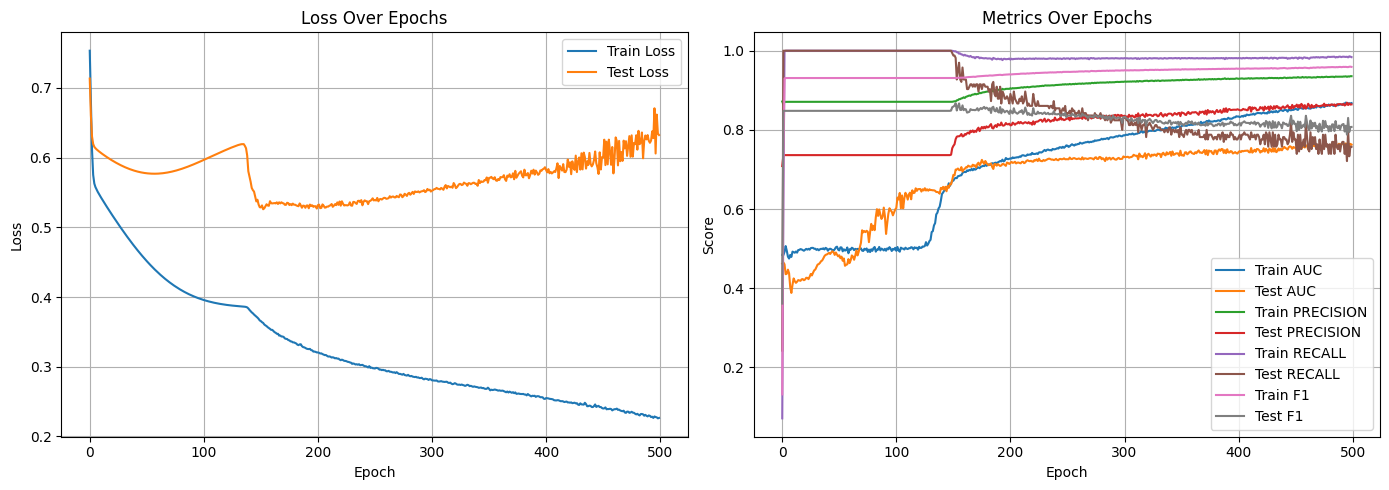

In [77]:
import numpy as np


import numpy as np
import numpy as np

def prepare_dataset_survival_window_increment(
    df, n_history=3, n_survival_window=3, cutoff_year=2013, n_increment=1, upweight_failed=10
):
    train_X, train_y, test_X, test_y = [], [], [], []
    unique_companies = df['company_name'].unique()

    for company in unique_companies:
        company_data = df[df['company_name'] == company].sort_values('year').reset_index(drop=True)
        years = company_data['year'].values
        labels = company_data['status_label'].values
        features = company_data.drop(columns=['company_name', 'year', 'status_label']).values

        if len(features) < n_history + n_survival_window:
            continue

        for i in range(0, len(features) - n_history - n_survival_window + 1, n_increment):
            X_seq = features[i:i + n_history]
            end_year = years[i + n_history - 1]

            survival_window_labels = labels[i + n_history:i + n_history + n_survival_window]

            if 'failed' in survival_window_labels:
                y_label = 1
            elif 'alive' in survival_window_labels:
                y_label = 0
            else:
                continue

            if end_year + n_survival_window <= cutoff_year:
                train_X.append(X_seq)
                train_y.append(y_label)
                if upweight_failed and y_label == 1:
                    for _ in range(upweight_failed - 1):
                        train_X.append(X_seq)
                        train_y.append(y_label)
            else:
                test_X.append(X_seq)
                test_y.append(y_label)
                if upweight_failed and y_label == 1:
                    for _ in range(upweight_failed - 1):
                        test_X.append(X_seq)
                        test_y.append(y_label)

    return (np.array(train_X), np.array(train_y),
            np.array(test_X), np.array(test_y))

# Load your DataFrame
# df = pd.read_csv("your_data.csv")

# Prepare datasets
X_train, y_train, X_test, y_test =  prepare_dataset_survival_window_increment(df, n_history=5,n_increment  = 2, n_survival_window=3, cutoff_year=2013,
                                                                                   upweight_failed=100)

# Dataset and loaders
train_dataset = CompanyFailureDataset(X_train, y_train)
test_dataset = CompanyFailureDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=8192, shuffle=True, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=8192, shuffle=False, pin_memory=True)

# Model setup
input_dim = X_train.shape[2]
model = TransformerFailurePredictor(input_dim, d_model=8).to(device)

# Training with logging of train metrics
def train_model_with_train_metrics(model, train_loader, test_loader, device, num_epochs=100, lr=1e-4):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.BCEWithLogitsLoss()

    metrics = {'train_loss': [], 'test_loss': [], 'train_auc': [], 'test_auc': [],
               'train_precision': [], 'test_precision': [], 'train_recall': [], 'test_recall': [],
               'train_f1': [], 'test_f1': []}

    for epoch in range(num_epochs):
        model.train()
        total_train_loss, train_outputs, train_labels = 0, [], []

        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            total_train_loss += loss.item() * X_batch.size(0)
            train_outputs.append(outputs.detach().cpu())
            train_labels.append(y_batch.cpu())

        avg_train_loss = total_train_loss / len(train_loader.dataset)
        train_probs = torch.sigmoid(torch.cat(train_outputs)).numpy()
        train_preds = (train_probs > 0.5).astype(int)
        train_true = torch.cat(train_labels).numpy()

        metrics['train_loss'].append(avg_train_loss)
        metrics['train_auc'].append(roc_auc_score(train_true, train_probs))
        metrics['train_precision'].append(precision_score(train_true, train_preds, zero_division=0))
        metrics['train_recall'].append(recall_score(train_true, train_preds, zero_division=0))
        metrics['train_f1'].append(f1_score(train_true, train_preds, zero_division=0))

        # Evaluation on test set
        model.eval()
        test_loss, test_outputs, test_labels = 0, [], []

        with torch.no_grad():
            for X_batch, y_batch in test_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
                test_loss += loss.item() * X_batch.size(0)
                test_outputs.append(outputs.cpu())
                test_labels.append(y_batch.cpu())

        avg_test_loss = test_loss / len(test_loader.dataset)
        test_probs = torch.sigmoid(torch.cat(test_outputs)).numpy()
        test_preds = (test_probs > 0.5).astype(int)
        test_true = torch.cat(test_labels).numpy()

        metrics['test_loss'].append(avg_test_loss)
        metrics['test_auc'].append(roc_auc_score(test_true, test_probs))
        metrics['test_precision'].append(precision_score(test_true, test_preds, zero_division=0))
        metrics['test_recall'].append(recall_score(test_true, test_preds, zero_division=0))
        metrics['test_f1'].append(f1_score(test_true, test_preds, zero_division=0))

        print(f"Epoch {epoch + 1}/{num_epochs} - Train Loss: {avg_train_loss:.4f}, Test Loss: {avg_test_loss:.4f}")

    return metrics

# Training
metrics = train_model_with_train_metrics(model, train_loader, test_loader, device, num_epochs=500, lr=1e-4)

# Plotting loss and metrics
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(metrics['train_loss'], label='Train Loss')
plt.plot(metrics['test_loss'], label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Over Epochs')
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
for metric in ['auc', 'precision', 'recall', 'f1']:
    plt.plot(metrics[f'train_{metric}'], label=f'Train {metric.upper()}')
    plt.plot(metrics[f'test_{metric}'], label=f'Test {metric.upper()}')

plt.xlabel('Epoch')
plt.ylabel('Score')
plt.title('Metrics Over Epochs')
plt.legend()
plt.grid()

plt.tight_layout()
plt.savefig('train_test_metrics_survival_window.pdf')

what does this mean?
if we loosen our tasks to: does this company fails within the future 3 year window? its much easier
in continuous setup this is similar to $ \bar F (t= \Delta t) - \bar F (t)$
what does this mean in real life? as the company is not doing well, it might be ambigious whether one wants to give up now or one year later?


further if all censoring is on the same year, then it is close to $censoring \perp survival$, but is it the case?

Future work:

replace this transformer model to a much simpler structured state-space model, and see if any equivalency shows between that model and AR model and conditional failure with linear models from past covariates.

In [ ]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape   

In [ ]:
# Summarize the values of y_train
unique_y, counts_y = np.unique(y_train, return_counts=True)
print("Summary of y_train:")
for value, count in zip(unique_y, counts_y):
    print(f"Value: {value}, Count: {count}")

# Summarize the values of y_test
unique_y_test, counts_y_test = np.unique(y_test, return_counts=True)
print("\nSummary of y_test:")
for value, count in zip(unique_y_test, counts_y_test):
    print(f"Value: {value}, Count: {count}")

In [ ]:
# import torch
# import torch.nn as nn

# class GRUFailurePredictor(nn.Module):
#     def __init__(self, input_dim, hidden_dim=32, num_layers=1):
#         super().__init__()
#         self.gru = nn.GRU(input_dim, hidden_dim, num_layers=num_layers, batch_first=True)
#         self.classifier = nn.Sequential(
#             nn.Linear(hidden_dim, 16),
#             nn.ReLU(),
#             nn.Linear(16, 1)
#         )

#     def forward(self, x):
#         out, _ = self.gru(x)  # out: (batch, seq_len, hidden_dim)
#         out = out[:, -1, :]   # Take the output from the last time step
#         return self.classifier(out).squeeze(-1)


# model2= GRUFailurePredictor(input_dim=X_seq.shape[2]).to(device)
# train_model(model2,loader, device, num_epochs=300, lr=1e-4)


In [ ]:
# !pip install mamba-ssm

In [ ]:
# import torch
# import torch.nn as nn
# from mamba_ssm import Mamba

# class MambaFailurePredictor(nn.Module):
#     def __init__(self, input_dim, d_model=64):
#         super().__init__()
#         self.embedding = nn.Linear(input_dim, d_model)
#         self.mamba = Mamba(d_model=d_model)
#         self.classifier = nn.Sequential(
#             nn.Linear(d_model, 16),
#             nn.ReLU(),
#             nn.Linear(16, 1)
#         )

#     def forward(self, x):
#         x = self.embedding(x)  # (batch, seq_len, d_model)
#         x = self.mamba(x)      # (batch, seq_len, d_model)
#         x = x.mean(dim=1)      # Global average pooling
#         return self.classifier(x).squeeze(-1)


# model = MambaFailurePredictor(input_dim=X_seq.shape[2]).to(device)
# train_model(model, loader, device, num_epochs=50, lr=1e-4)
